# Requirements

In [3]:
!pip install shap

     |████████████████████████████████| 564 kB 1.6 MB/s 


In [17]:
!pip install hazm

     |████████████████████████████████| 316 kB 1.6 MB/s 
     |████████████████████████████████| 1.4 MB 31.6 MB/s 
     |████████████████████████████████| 233 kB 46.6 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=6ad9071a6ad65a1d0e5a4e889f54ed7a42ee199f61a34a7af55e25dfb52bf093
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=153874 sha256=6ffeb40332abfd6f2d47c9c6af34252b8e03000776f46f9ee5f77a62f30fa3c6
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


# Get fast text
Download FastText word vectors file for Persian

In [24]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec

--2022-01-07 14:20:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105157170 (1.0G) [binary/octet-stream]
Saving to: ‘wiki.fa.vec’

wiki.fa.vec         100%[===================>]   1.03G  13.1MB/s    in 70s     

2022-01-07 14:21:35 (15.0 MB/s) - ‘wiki.fa.vec’ saved [1105157170/1105157170]



In [64]:
import time
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
# from keras.utils import plot_model

# Word Embedding
from gensim.models import KeyedVectors

# Preprocessing
# from stopwords_guilannlp import stopwords_output
from hazm import *

# Visualization
import matplotlib.pyplot as plt
import shap
%matplotlib inline
pd.set_option('display.max_colwidth', None)

# Measuring metrics
from sklearn import metrics
from sklearn.metrics import f1_score

# Loading Data

In [5]:
train_df = pd.read_csv("data/train.csv", encoding="utf-8")
eval_df = pd.read_csv("data/eval.csv", encoding="utf-8")
test_df = pd.read_csv("data/test.csv", encoding="utf-8")

In [28]:
train_df.info()
print()
eval_df.info()
print()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  800 non-null    int64  
 1   comment     800 non-null    object 
 2   rate        800 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   comment     200 non-null    object 
 2   rate        200 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  170 non-null    int64  
 1   comment     170 non-nul

In [6]:
# convert rate to 1 and -1 for binary classification
train_df.loc[train_df['rate'] >= 0, 'rate'] = 1
train_df.loc[train_df['rate'] < 0, 'rate'] = 0

eval_df.loc[eval_df['rate'] >= 0, 'rate'] = 1
eval_df.loc[eval_df['rate'] < 0, 'rate'] = 0

test_df.loc[test_df['rate'] >= 0, 'rate'] = 1
test_df.loc[test_df['rate'] < 0, 'rate'] = 0

In [8]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(train_df['rate'].values)
cnt = dict(cnt)
print(cnt)

{1.0: 606, 0.0: 194}


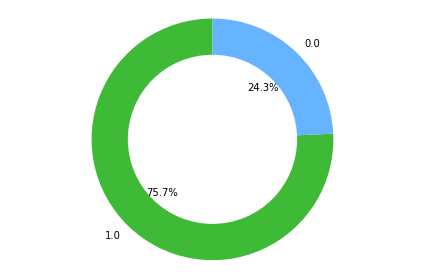

In [9]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

# Preprocess

In [20]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    # Normalize document using Hazm Normalizer
    doc = normalizer.normalize(doc)
    # Tokenize text
    tokenized = word_tokenize(doc)
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]
    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    # Lemmatize sentence words using Hazm Lemmatizer
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    tokens = ' '.join(tokens)
    return tokens

# Prepare FastText Model

In [29]:
EMBEDDING_FILE = 'wiki.fa.vec'

def import_with_gensim(file_address):
  # Creating the model
  ft_model = KeyedVectors.load_word2vec_format(file_address)
  # Getting the tokens
  ft_words = []
  for ft_word in ft_model.vocab:
      ft_words.append(ft_word)
  return ft_model, ft_words
  
ft_model, ft_words = import_with_gensim(EMBEDDING_FILE)

In [30]:
# FastText embedding dimensionality
embed_size = 300

In [31]:
# We get the mean and standard deviation of the embedding weights so that we could maintain the
# same statistics for the rest of our own random generated weights.
embedding_list = list()
for w in ft_words:
  embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

# Apply preprocessing to data

In [68]:
# Apply preprocessing step to training data
x_train = train_df['comment'].values
y_train = train_df['rate'].values
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [69]:
# Apply preprocessing step to eval data
x_eval = eval_df['comment'].values
y_eval = eval_df['rate'].values
eval_docs = np.empty_like(x_eval)
for index, document in enumerate(x_eval):
  eval_docs[index] = clean_doc(document)

In [70]:
# Apply preprocessing step to eval data
x_test = test_df['comment'].values
y_test = test_df['rate'].values
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

# Setting tokenizer up

In [47]:
num_words = 2500

# Create the tokenizer
tokenizer = Tokenizer()

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [49]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])
print("max length:", max_length)

max length: 598


# Embed sentences

In [52]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [54]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)
print('vocab size:', vocab_size)

vocab size: 3718


In [55]:
nb_words = len(tokenizer.word_index)

# the size will be Number of Words in Vocab X Embedding Size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i -= 1
    if word in ft_model.vocab:
        embedding_vector = ft_model[word]
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    # Unknown words
    else:  
        embedding_vector = ft_model['subdivision_name']
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

total embedded: 3718 common words
Embedding matrix shape: (3718, 300)


In [57]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [58]:
# Embed eval sequences
encoded_docs = tokenizer.texts_to_sequences(eval_docs)
# Pad eval sequences
x_eval_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Model

# CNN Model

In [98]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=7, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(1, activation='sigmoid'))

In [94]:
model_cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 10

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         1115400   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          57664     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 64)         

In [95]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, y_train, batch_size=batch_size_cnn, epochs=epochs_cnn)

Epoch 1/10
13/13 [==============================] - 2s 63ms/step - loss: 0.5559 - accuracy: 0.7575
Epoch 2/10
13/13 [==============================] - 0s 22ms/step - loss: 0.5501 - accuracy: 0.7575
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 0.5343 - accuracy: 0.7575
Epoch 4/10
13/13 [==============================] - 0s 22ms/step - loss: 0.5057 - accuracy: 0.7600
Epoch 5/10
13/13 [==============================] - 0s 22ms/step - loss: 0.4641 - accuracy: 0.7638
Epoch 6/10
13/13 [==============================] - 0s 22ms/step - loss: 0.4424 - accuracy: 0.8188
Epoch 7/10
13/13 [==============================] - 0s 22ms/step - loss: 0.3360 - accuracy: 0.8375
Epoch 8/10
13/13 [==============================] - 0s 21ms/step - loss: 0.2372 - accuracy: 0.9062
Epoch 9/10
13/13 [==============================] - 0s 22ms/step - loss: 0.1641 - accuracy: 0.9438
Epoch 10/10
13/13 [==============================] - 0s 23ms/step - loss: 0.1055 - accuracy: 0.9688


In [96]:
# Evaluate model on test
loss_cnn, acc_cnn = model_cnn.evaluate(x_train_padded, y_train, verbose=0)
print('Train Accuracy: %f' % (acc_cnn*100))

Train Accuracy: 99.374998


In [97]:
# Evaluate model on test
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 72.941178


In [92]:
# Get prediction label
predict_x = model_cnn.predict(x_test_padded) 
y_pred_cnn =np.argmax(predict_x, axis=1)